In [13]:
import numpy as np
from numpy.random import multivariate_normal
import scipy as scp
import sklearn
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import normalized_mutual_info_score as nmi
import matplotlib.pyplot as plt

N_SAMPLES = 1000

In [14]:
def get_synth_data():
    c1_means = [[1, 1],[1, 2],[1, 1]]
    c2_means = [[3, 4],[2, 2],[3, 3]]
    c1_cov = list()
    c1_cov.append([[1, 0.5],[0.5, 1.5]])
    c1_cov.append([[1, -0.2],[-0.2, 1]])
    c1_cov.append([[1.2, 0.2],[0.2, 1]])
    c2_cov = list()
    c2_cov.append([[0.3, 0.2],[0.2, 0.6]])
    c2_cov.append([[0.6, 0.1],[0.1, 0.5]])
    c2_cov.append([[1, 0.4],[0.4, 0.7]])
    means = [c1_means, c2_means]
    cov = [c1_cov, c2_cov]
    v_data =  [[],[],[]]
    
    for co in range(2):
        for vi in range(3):
            samples = multivariate_normal(means[co][vi], cov[co][vi], N_SAMPLES)
            v_data[vi].append(samples)
            
    for vi in range(3):
        v_data[vi] = np.vstack(v_data[vi])
    
    labels = np.concatenate((np.zeros((N_SAMPLES,)), np.ones((N_SAMPLES,))))
    
    shuffle_inds = np.random.permutation(N_SAMPLES * 2)
    for vi in range(3):
        v_data[vi] = v_data[vi][shuffle_inds]
    labels = labels[shuffle_inds]
    
    return v_data, labels

In [15]:
v_data, labels = get_synth_data()

In [16]:
def gaussian_sim(X_mat):
    
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    sq_dists = np.square(distances)
    norm_dists = sq_dists / (2 * (np.median(sq_dists)))
    sims = np.exp(-norm_dists)
    
    return sims
    
def sym(S_mat):
    return (S_mat + np.transpose(S_mat))/2

def comp_laplacian(X_mat):
    D_mat = np.diag(np.sum(X_mat, axis=1))
    D_alt = np.eye(X_mat.shape[0])
    for ind in range(X_mat.shape[0]):
        if(D_mat[ind, ind] != 0):
            D_alt[ind, ind] /= np.sqrt(D_mat[ind, ind])
    laplacian = D_alt @ X_mat @ D_alt
    return laplacian

def comp_eigs(X_mat, k):
    laplacian = comp_laplacian(X_mat)
    e_vals, e_vecs = np.linalg.eig(laplacian)
    indices = np.argsort(e_vals)[-k:]
    e_vecs = e_vecs[:,indices]
    return e_vecs

In [33]:
def multiview_spectral(v_data, labels, k=2, num_iter = 5):
    #Compute the similarities matrices
    similarities = [gaussian_sim(dat) for dat in v_data]
    
    #Initialize matrices of eigenvectors
    U_mats = [comp_eigs(sim, k) for sim in similarities]
    eig_sums = [np.matmul(u_mat, np.transpose(u_mat)) for u_mat in U_mats]
    total_eigs = np.sum(np.array(eig_sums), axis=0)
    
    #Iteratively compute new graph similarities, laplacians, and eigenvectors
    for iter in range(num_iter):
        print(iter)
        new_sims = list()
        for view in range(len(v_data)):
            mat = np.matmul(total_eigs - eig_sums[view], similarities[view])
            new_sims.append(sym(mat))
            
        similarities = new_sims   
        U_mats = [comp_eigs(sim, k) for sim in similarities]
        eig_sums = [np.matmul(u_mat, np.transpose(u_mat)) for u_mat in U_mats]
        total_eigs = np.sum(np.array(eig_sums), axis=0)
            
    #Row normalize 
    for view in range(len(v_data)):
        U_mats[view] /= np.max(U_mats[view], axis=1).reshape((-1, 1))
    #Columnwise concatenation across all views
    V_mat = np.hstack(U_mats)
        
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(U_mats[0])
    return clusters
    

In [6]:
clusters = multiview_spectral(v_data, labels)


0


C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


1
2
3
4
5
6
7
8
9


C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


In [7]:
score = nmi(labels, clusters)
print(score)

0.8001425720918351


In [8]:
print()
print(clusters.sum())


1050


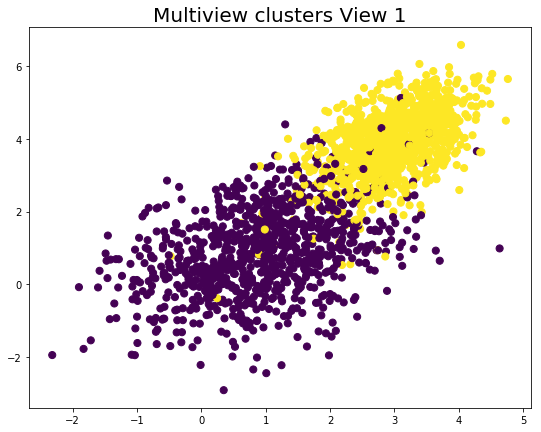

In [9]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview clusters View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=clusters,s=dot_size, cmap=cmap)

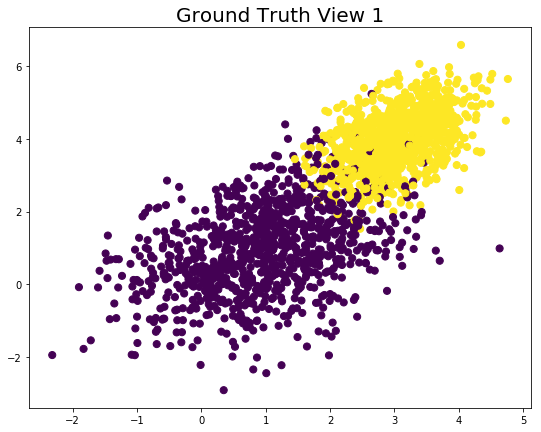

In [10]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=labels,s=dot_size, cmap=cmap)

In [22]:
U_SAMPLES = 200

def get_dist(X_mat):
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    return distances

def get_UCI():
    
    fac_file = 'fac.txt'
    fou_file = 'fou.txt'
    fac_feats = np.loadtxt(fac_file, delimiter=',')
    fou_feats = np.loadtxt(fou_file, delimiter=',')
    v_data = [fou_feats, fac_feats]
    
    labels = list()
    for ind in range(10):
        labels.append(np.ones(U_SAMPLES,) * ind)
    labels = np.concatenate(labels)
    print(labels.shape)
    
        
    shuffle_inds = np.random.permutation(U_SAMPLES* 10)
    for vi in range(2):
        v_data[vi] = v_data[vi][shuffle_inds]
    labels = labels[shuffle_inds]
    return v_data, labels

In [23]:
v_data, labels = get_UCI()

(2000,)


In [24]:
#Single view scikit learn results 

#View 1
distances1 = get_dist(v_data[0])
g1= 1/ (2 * np.median(distances1) **2)
S_Cluster = SpectralClustering(n_clusters=10, gamma = g1)
v1_clusters = S_Cluster.fit_predict(v_data[0]) 
v1_score = nmi(labels, v1_clusters)
print("NMI for view 1 is " + str(v1_score))


#View 2
distances2 = get_dist(v_data[1])
g2= 1/ (2 * np.median(distances2) **2)
S_Cluster = SpectralClustering(n_clusters=10, gamma = g2)
v2_clusters = S_Cluster.fit_predict(v_data[1]) 
v2_score = nmi(labels, v2_clusters)
print("NMI for view 2 is " + str(v2_score))

NameError: name 'SpectralClustering' is not defined

In [34]:
clusters = multiview_spectral(v_data, labels)
score = nmi(labels, clusters)
print(score)

0
1


C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


2
3
4
0.3283891635920645


C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
